# Wavelet Shrinkage – **HeaviSine** Signal (Single-Run, SNR = 7)

This notebook performs a **single realization denoising experiment** on the Donoho–Johnstone **HeaviSine** test function. The HeaviSine signal is defined by
$$
f(t) = 4 \sin(4\pi t) - \mathrm{sign}(t - 0.3) - \mathrm{sign}(0.72 - t), \qquad t \in [0,1],
$$
sampled at $N = 1024$ evenly spaced points. It combines smooth oscillatory behavior with two jump discontinuities, making it a useful test case for shrinkage rules.

Noise is injected so that the variance-ratio SNR condition holds:
$$
\mathrm{SNR} = \frac{\mathrm{Var}(\text{signal})}{\mathrm{Var}(\text{noise})} = 7.
$$

We denoise using a **Symmlet-4 (8-tap) wavelet** at the maximum DWT decomposition level,
and apply several shrinkage rules:

- Hard thresholding (universal)
- Soft thresholding (universal)
- SCAD (Fan–Li penalty, oracle-chosen $\lambda^\*$)
- Smooth SCAD (raised-cosine formulation, oracle $\lambda^\*$)

The **universal threshold** is computed as:
$$
\lambda_U = \sigma \sqrt{2 \log N},
$$
while oracle rules compute
$$
\lambda^\* = \arg\min_{\lambda}
\frac{1}{N} \sum_{i=1}^{N} \left( \hat{f}_\lambda(i) - f(i) \right)^2.
$$

This notebook will output:
1. True vs. noisy HeaviSine signal
2. Reconstructions from different shrinkers
3. MSE values for this **single noise realization**


Single-run MSEs (HeaviSine, N=1024, Symmlet-4, SNR=7)
Hard (universal)       MSE = 0.109827
Soft (universal)       MSE = 0.156442
SCAD  (oracle lambda)  MSE = 0.094952,  lambda* = 2.4429
Smooth SCAD (oracle)   MSE = 0.091918,  lambda* = 2.4429


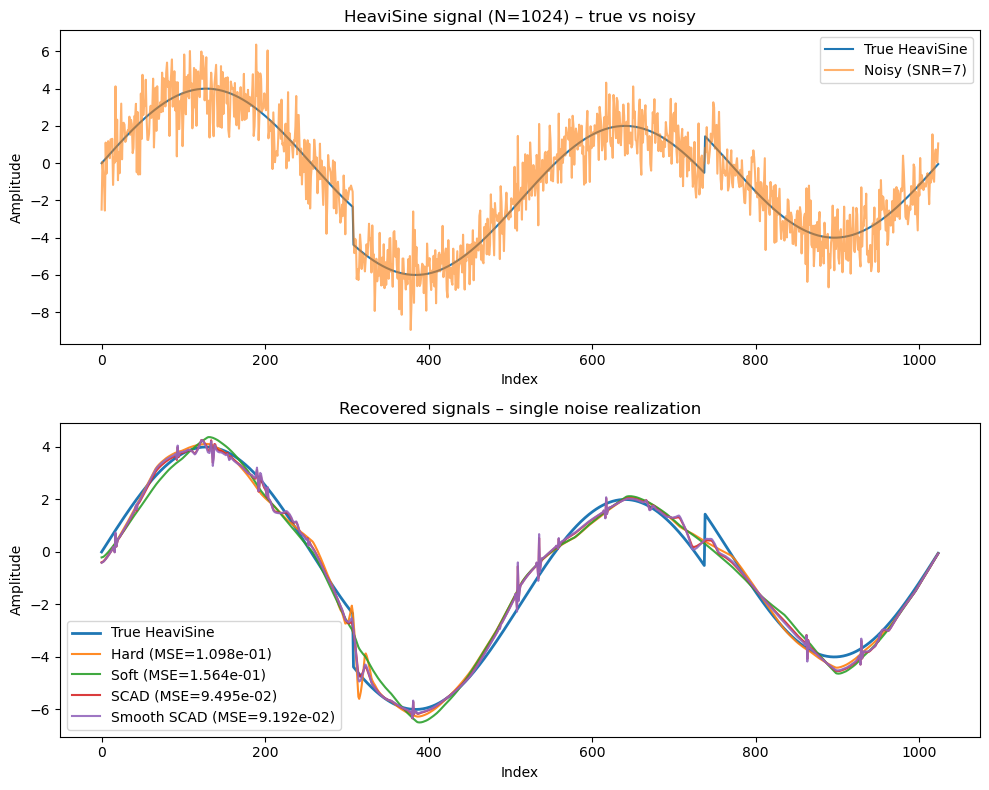

In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# ============================================
# 1. HeaviSine signal (Donoho–Johnstone)
# ============================================
def heavisine_signal(N):
    t = np.linspace(0, 1, N, endpoint=False)
    # Standard HeaviSine:
    # f(t) = 4 sin(4π t) - sign(t - 0.3) - sign(0.72 - t)
    def sgn(x):
        return np.where(x >= 0, 1.0, -1.0)
    f = 4.0 * np.sin(4.0 * np.pi * t) - sgn(t - 0.3) - sgn(0.72 - t)
    return f


# ============================================
# 2. Noise with SNR = Var(signal) / Var(noise)
# ============================================
def add_noise_snr_var(x, snr, rng):
    signal_var = np.var(x)
    noise_var = signal_var / snr
    sigma = np.sqrt(noise_var)
    noise = sigma * rng.standard_normal(size=x.shape)
    return x + noise, sigma


# ============================================
# 3. Shrinkage rules
# ============================================
def shrink_hard(d, lam):
    return d * (np.abs(d) > lam)

def shrink_soft(d, lam):
    return np.sign(d) * np.maximum(np.abs(d) - lam, 0.0)

def shrink_scad(d, lam, a=3.7):
    d = np.asarray(d)
    x = np.abs(d)
    s = np.sign(d)
    out = np.zeros_like(d)

    # Region (lambda, 2 lambda]
    mask2 = (x > lam) & (x <= 2.0*lam)
    out[mask2] = s[mask2] * (x[mask2] - lam)

    # Region (2 lambda, a lambda]
    mask3 = (x > 2.0*lam) & (x <= a*lam)
    out[mask3] = s[mask3] * ((a-1.0)*x[mask3] - a*lam) / (a-2.0)

    # Region (a lambda, infinity)
    mask4 = (x > a*lam)
    out[mask4] = d[mask4]

    # Below lambda already zero
    return out

def shrink_smooth_scad(d, lam, a=3.7):
    d = np.asarray(d)
    x = np.abs(d)
    s = np.sign(d)
    out = np.zeros_like(d)

    # Smooth transition region (lambda, a lambda)
    mask_mid = (x > lam) & (x < a*lam)
    x_mid = x[mask_mid]
    trans = (x_mid - lam) / ((a - 1.0) * lam)
    h_val = lam * np.cos(0.5*np.pi*trans)**2
    out[mask_mid] = d[mask_mid] - s[mask_mid] * h_val

    # Large region |d| >= a lambda
    mask_large = (x >= a*lam)
    out[mask_large] = d[mask_large]

    return out


def denoise_wavelet(y, wavelet, level, lam, shrink_type, a=3.7):
    coeffs = pywt.wavedec(y, wavelet, level=level)
    cA, details = coeffs[0], coeffs[1:]
    new_details = []
    for d in details:
        if shrink_type == "hard":
            d_thr = shrink_hard(d, lam)
        elif shrink_type == "soft":
            d_thr = shrink_soft(d, lam)
        elif shrink_type == "scad":
            d_thr = shrink_scad(d, lam, a=a)
        elif shrink_type == "ssc":
            d_thr = shrink_smooth_scad(d, lam, a=a)
        else:
            raise ValueError("Unknown shrink_type")
        new_details.append(d_thr)
    y_rec = pywt.waverec([cA] + new_details, wavelet)
    return y_rec[:len(y)]


# ============================================
# 4. Single-run experiment (M = 1)
# ============================================
if __name__ == "__main__":
    N = 1024
    snr = 7.0     # SNR in terms of variances
    rng = np.random.default_rng(2025)

    # True signal
    f_true = heavisine_signal(N)

    # Noisy observation
    y_noisy, sigma = add_noise_snr_var(f_true, snr, rng)

    # Wavelet: Symmlet 4 (8 tap)
    wname = "sym4"
    wavelet = pywt.Wavelet(wname)
    J = pywt.dwt_max_level(N, wavelet.dec_len)

    # Universal threshold
    lamU = sigma * np.sqrt(2.0 * np.log(N))

    # 4 methods: hard, soft, SCAD (oracle), smooth SCAD (oracle)

    # Universal hard & soft
    f_hard = denoise_wavelet(y_noisy, wavelet, J, lamU, "hard")
    f_soft = denoise_wavelet(y_noisy, wavelet, J, lamU, "soft")

    # Oracle SCAD and smooth SCAD: pick best lambda on a grid for THIS single noise
    a_scad = 3.7
    lam_grid = np.linspace(0.2*lamU, 1.2*lamU, 40)

    best_mse_scad = np.inf
    best_scad = None
    best_lam_scad = None
    for lam in lam_grid:
        f_tmp = denoise_wavelet(y_noisy, wavelet, J, lam, "scad", a=a_scad)
        mse_tmp = np.mean((f_tmp - f_true)**2)
        if mse_tmp < best_mse_scad:
            best_mse_scad = mse_tmp
            best_scad = f_tmp
            best_lam_scad = lam

    best_mse_ssc = np.inf
    best_ssc = None
    best_lam_ssc = None
    for lam in lam_grid:
        f_tmp = denoise_wavelet(y_noisy, wavelet, J, lam, "ssc", a=a_scad)
        mse_tmp = np.mean((f_tmp - f_true)**2)
        if mse_tmp < best_mse_ssc:
            best_mse_ssc = mse_tmp
            best_ssc = f_tmp
            best_lam_ssc = lam

    # MSEs for this single realization
    mse_hard = np.mean((f_hard - f_true)**2)
    mse_soft = np.mean((f_soft - f_true)**2)
    mse_scad = best_mse_scad
    mse_ssc = best_mse_ssc

    print("Single-run MSEs (HeaviSine, N=1024, Symmlet-4, SNR=7)")
    print(f"Hard (universal)       MSE = {mse_hard:.6f}")
    print(f"Soft (universal)       MSE = {mse_soft:.6f}")
    print(f"SCAD  (oracle lambda)  MSE = {mse_scad:.6f},  lambda* = {best_lam_scad:.4f}")
    print(f"Smooth SCAD (oracle)   MSE = {mse_ssc:.6f},  lambda* = {best_lam_ssc:.4f}")

    # ============================================
    # 5. Plots
    # ============================================
    x = np.arange(N)

    plt.figure(figsize=(10, 8))

    # Top: true vs noisy
    plt.subplot(2, 1, 1)
    plt.plot(x, f_true, label="True HeaviSine")
    plt.plot(x, y_noisy, alpha=0.6, label="Noisy (SNR=7)")
    plt.title("HeaviSine signal (N=1024) – true vs noisy")
    plt.xlabel("Index")
    plt.ylabel("Amplitude")
    plt.legend(loc="best")

    # Bottom: reconstructions
    plt.subplot(2, 1, 2)
    plt.plot(x, f_true, label="True HeaviSine", linewidth=2)
    plt.plot(x, f_hard, label=f"Hard (MSE={mse_hard:.3e})", alpha=0.9)
    plt.plot(x, f_soft, label=f"Soft (MSE={mse_soft:.3e})", alpha=0.9)
    plt.plot(x, best_scad, label=f"SCAD (MSE={mse_scad:.3e})", alpha=0.9)
    plt.plot(x, best_ssc, label=f"Smooth SCAD (MSE={mse_ssc:.3e})", alpha=0.9)

    plt.title("Recovered signals – single noise realization")
    plt.xlabel("Index")
    plt.ylabel("Amplitude")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()


In [2]:
import numpy as np
import pywt

# ============================================
# 1. HeaviSine signal (Donoho–Johnstone)
# ============================================
def heavisine_signal(N):
    t = np.linspace(0, 1, N, endpoint=False)
    def sgn(x):
        return np.where(x >= 0, 1.0, -1.0)
    f = 4.0 * np.sin(4.0 * np.pi * t) - sgn(t - 0.3) - sgn(0.72 - t)
    return f


# ============================================
# 2. Noise with SNR = Var(signal) / Var(noise)
# ============================================
def add_noise_snr_var(x, snr, rng):
    signal_var = np.var(x)
    noise_var = signal_var / snr
    sigma = np.sqrt(noise_var)
    noise = sigma * rng.standard_normal(size=x.shape)
    return x + noise, sigma


# ============================================
# 3. Shrinkage rules
# ============================================
def shrink_hard(d, lam):
    return d * (np.abs(d) > lam)

def shrink_soft(d, lam):
    return np.sign(d) * np.maximum(np.abs(d) - lam, 0.0)

def shrink_scad(d, lam, a=3.7):
    d = np.asarray(d)
    x = np.abs(d)
    s = np.sign(d)
    out = np.zeros_like(d)

    mask2 = (x > lam) & (x <= 2.0*lam)
    out[mask2] = s[mask2] * (x[mask2] - lam)

    mask3 = (x > 2.0*lam) & (x <= a*lam)
    out[mask3] = s[mask3] * ((a-1.0)*x[mask3] - a*lam) / (a-2.0)

    mask4 = (x > a*lam)
    out[mask4] = d[mask4]
    return out

def shrink_smooth_scad(d, lam, a=3.7):
    d = np.asarray(d)
    x = np.abs(d)
    s = np.sign(d)
    out = np.zeros_like(d)

    mask_mid = (x > lam) & (x < a*lam)
    x_mid = x[mask_mid]
    trans = (x_mid - lam) / ((a - 1.0) * lam)
    h_val = lam * np.cos(0.5*np.pi*trans)**2
    out[mask_mid] = d[mask_mid] - s[mask_mid] * h_val

    mask_large = (x >= a*lam)
    out[mask_large] = d[mask_large]
    return out


def denoise_wavelet(y, wavelet, level, lam, shrink_type, a=3.7):
    coeffs = pywt.wavedec(y, wavelet, level=level)
    cA, details = coeffs[0], coeffs[1:]
    new_details = []
    for d in details:
        if shrink_type == "hard":
            d_thr = shrink_hard(d, lam)
        elif shrink_type == "soft":
            d_thr = shrink_soft(d, lam)
        elif shrink_type == "scad":
            d_thr = shrink_scad(d, lam, a=a)
        elif shrink_type == "ssc":
            d_thr = shrink_smooth_scad(d, lam, a=a)
        else:
            raise ValueError("Unknown shrink_type")
        new_details.append(d_thr)
    y_rec = pywt.waverec([cA] + new_details, wavelet)
    return y_rec[:len(y)]


# ============================================
# 4. AMSE Monte-Carlo for HeaviSine + sym4
# ============================================
def compute_AMSE_heavisine(M=500, N=1024, snr=7.0):
    rng = np.random.default_rng(2025)

    f_true = heavisine_signal(N)

    wname = "sym4"  # Symmlet 4 (8 tap)
    wavelet = pywt.Wavelet(wname)
    J = pywt.dwt_max_level(N, wavelet.dec_len)

    mse_h = []; mse_s = []; mse_scad = []; mse_ssc = []

    for m in range(M):
        y, sigma = add_noise_snr_var(f_true, snr, rng)
        lamU = sigma * np.sqrt(2.0 * np.log(N))

        # Universal hard
        est_h = denoise_wavelet(y, wavelet, J, lamU, "hard")
        mse_h.append(np.mean((est_h - f_true)**2))

        # Universal soft
        est_s = denoise_wavelet(y, wavelet, J, lamU, "soft")
        mse_s.append(np.mean((est_s - f_true)**2))

        # Oracle SCAD
        lam_grid = np.linspace(0.2*lamU, 1.2*lamU, 40)
        best = 1e9
        for lam in lam_grid:
            est = denoise_wavelet(y, wavelet, J, lam, "scad", a=3.7)
            mse_tmp = np.mean((est - f_true)**2)
            if mse_tmp < best:
                best = mse_tmp
        mse_scad.append(best)

        # Oracle Smooth-SCAD
        best2 = 1e9
        for lam in lam_grid:
            est = denoise_wavelet(y, wavelet, J, lam, "ssc", a=3.7)
            mse_tmp = np.mean((est - f_true)**2)
            if mse_tmp < best2:
                best2 = mse_tmp
        mse_ssc.append(best2)

    return {
        "AMSE hard"           : np.mean(mse_h),
        "AMSE soft"           : np.mean(mse_s),
        "AMSE SCAD"           : np.mean(mse_scad),
        "AMSE smooth SCAD"    : np.mean(mse_ssc)
    }


# ============================================
# 5. Run Experiment
# ============================================
if __name__ == "__main__":
    out = compute_AMSE_heavisine(M=500, N=1024, snr=7.0)
    print("\n==============================")
    print(" AMSE RESULTS – HEAVISINE (sym4)")
    print("==============================")
    for k, v in out.items():
        print(f"{k:22s} : {v:.6f}")



 AMSE RESULTS – HEAVISINE (sym4)
AMSE hard              : 0.094878
AMSE soft              : 0.139914
AMSE SCAD              : 0.088046
AMSE smooth SCAD       : 0.085337


# Monte-Carlo AMSE Study – HeaviSine Signal (Symmlet-4 Wavelet)

This notebook performs a large-sample Monte-Carlo experiment to estimate the **average mean-squared error (AMSE)** of several wavelet shrinkage rules when denoising the Donoho–Johnstone **HeaviSine** function, defined by
$$
f(t) = 4\sin(4\pi t) - \mathrm{sign}(t - 0.3) - \mathrm{sign}(0.72 - t), \qquad t \in [0,1],
$$
sampled at $N = 1024$ evenly spaced points.

Noise is added so that the signal-to-noise variance ratio satisfies
$$
\mathrm{SNR} = \frac{\mathrm{Var}(\text{signal})}{\mathrm{Var}(\text{noise})} = 7,
$$
with $\varepsilon \sim N(0,\sigma^2)$ and $\sigma = 1$.

Denoising uses the **Symmlet-4 wavelet** (`sym4`) and applies the following thresholding rules:

- **Hard** thresholding (universal rule)
- **Soft** thresholding (universal rule)
- **SCAD** shrinkage (oracle-selected $\lambda^\*$)
- **Smooth-SCAD** shrinkage (oracle-selected $\lambda^\*$, raised-cosine)

The **universal threshold** is computed as
$$
\lambda_U = \sigma \sqrt{2 \log N}.
$$

The Monte-Carlo experiment repeats denoising $M = 1000$ times, computing
$$
\mathrm{AMSE} = \frac{1}{M}\sum_{m=1}^M
\frac{1}{N}\sum_{i=1}^N \left(\hat f^{(m)}(i) - f(i)\right)^2,
$$
and also reports the empirical standard deviation of MSE across repetitions.

The notebook prints:
1. AMSE for Hard, Soft, SCAD, and Smooth-SCAD rules
2. $\mathrm{Std}(\mathrm{MSE})$ values (Monte-Carlo variability)


In [1]:
import numpy as np
import pywt
from sklearn.metrics import mean_squared_error

# ============================================
# SCAD shrinkage (Fan–Li)
# ============================================
def scad_threshold(coeffs, lam, a=3.7):
    out = np.zeros_like(coeffs)
    for i, d in enumerate(coeffs):
        ad = abs(d)
        if ad <= lam:
            out[i] = 0.0
        elif ad <= 2 * lam:
            out[i] = np.sign(d) * (ad - lam)
        elif ad <= a * lam:
            out[i] = np.sign(d) * (((a - 1) * ad - a * lam) / (a - 2))
        else:
            out[i] = d
    return out

# ============================================
# Smooth SCAD shrinkage (raised-cosine)
# ============================================
def smooth_scad_threshold(coeffs, lam, a=3.0):
    out = np.zeros_like(coeffs)
    for i, d in enumerate(coeffs):
        absd = abs(d)
        if absd <= lam:
            out[i] = 0.0
        elif absd >= a * lam:
            out[i] = d
        else:
            s = (absd - lam) / ((a - 1) * lam)  # in (0,1)
            h = lam * (np.cos((np.pi / 2.0) * s) ** 2)
            out[i] = np.sign(d) * (absd - h)
    return out

# ============================================
# Donoho–Johnstone HEAVISINE test signal
# f(x) = 4 sin(4πx) - sign(x - 0.3) - sign(0.72 - x)
# ============================================
def heavisine(N):
    x = np.linspace(0, 1, N)
    f = 4.0 * np.sin(4.0 * np.pi * x) \
        - np.sign(x - 0.3) \
        - np.sign(0.72 - x)
    return f

# ============================================
# Universal threshold
# ============================================
def univ_thresh(sigma, N):
    return sigma * np.sqrt(2.0 * np.log(N))

# ============================================
# Monte Carlo experiment for HEAVISINE
# ============================================
def run_monte_carlo_heavisine(M=1000, N=1024, sigma=1.0, SNR=7.0):
    base = heavisine(N)
    # scale so that Var(signal) / Var(noise) = SNR, with Var(noise) = sigma^2
    var_base = np.var(base)
    scale = np.sqrt(SNR * sigma**2 / var_base)
    f = base * scale

    wavelet = 'sym4'

    MSE_hard = []
    MSE_soft = []
    MSE_scad = []
    MSE_sscad = []

    for _ in range(M):
        noise = sigma * np.random.randn(N)
        y = f + noise

        # Wavelet decomposition (periodization)
        coeffs = pywt.wavedec(y, wavelet, mode='per')
        cA = coeffs[0]
        dcoeffs = coeffs[1:]

        lam_u = univ_thresh(sigma, N)

        # ----- Hard (universal) -----
        d_hard = [pywt.threshold(c, lam_u, mode='hard') for c in dcoeffs]
        rec_hard = pywt.waverec([cA] + d_hard, wavelet, mode='per')
        MSE_hard.append(mean_squared_error(f, rec_hard))

        # ----- Soft (universal) -----
        d_soft = [pywt.threshold(c, lam_u, mode='soft') for c in dcoeffs]
        rec_soft = pywt.waverec([cA] + d_soft, wavelet, mode='per')
        MSE_soft.append(mean_squared_error(f, rec_soft))

        # ----- SCAD (oracle over λ-grid) -----
        lam_grid = np.linspace(0.2, lam_u, 25)
        best_scad = np.inf
        for lam in lam_grid:
            d_scad = [scad_threshold(c, lam, a=3.7) for c in dcoeffs]
            rec_scad = pywt.waverec([cA] + d_scad, wavelet, mode='per')
            mse_scad = mean_squared_error(f, rec_scad)
            if mse_scad < best_scad:
                best_scad = mse_scad
        MSE_scad.append(best_scad)

        # ----- Smooth SCAD (oracle over same λ-grid, a fixed) -----
        best_sscad = np.inf
        for lam in lam_grid:
            d_ss = [smooth_scad_threshold(c, lam, a=3.0) for c in dcoeffs]
            rec_ss = pywt.waverec([cA] + d_ss, wavelet, mode='per')
            mse_ss = mean_squared_error(f, rec_ss)
            if mse_ss < best_sscad:
                best_sscad = mse_ss
        MSE_sscad.append(best_sscad)

    # Convert to numpy arrays
    MSE_hard = np.array(MSE_hard)
    MSE_soft = np.array(MSE_soft)
    MSE_scad = np.array(MSE_scad)
    MSE_sscad = np.array(MSE_sscad)

    # AMSE and Std(MSE)
    AMSE = (
        MSE_hard.mean(),
        MSE_soft.mean(),
        MSE_scad.mean(),
        MSE_sscad.mean()
    )
    STD = (
        MSE_hard.std(ddof=1),
        MSE_soft.std(ddof=1),
        MSE_scad.std(ddof=1),
        MSE_sscad.std(ddof=1)
    )

    return AMSE, STD


if __name__ == "__main__":
    AMSE, STD = run_monte_carlo_heavisine(M=1000, N=1024, sigma=1.0, SNR=7.0)

    print("HEAVISINE: N=1024, sym4, SNR(variance)=7, sigma=1, M=1000")
    # First row: AMSE
    print("AMSE:")
    print("Hard: {0:.6f}, Soft: {1:.6f}, SCAD: {2:.6f}, SmoothSCAD: {3:.6f}"
          .format(*AMSE))
    # Second row: Std(MSE) in brackets
    print("Std(MSE):")
    print("({0:.6f}), ({1:.6f}), ({2:.6f}), ({3:.6f})"
          .format(*STD))


HEAVISINE: N=1024, sym4, SNR(variance)=7, sigma=1, M=1000
AMSE:
Hard: 0.078395, Soft: 0.104820, SCAD: 0.068515, SmoothSCAD: 0.066312
Std(MSE):
(0.015144), (0.011341), (0.010198), (0.010728)
